In [1]:
%matplotlib inline

import numpy as np
from scipy.stats import multivariate_normal, norm, ks_2samp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle

from copy import deepcopy

import time

#import tqdm
from tqdm.notebook import tqdm

In [2]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_spd_matrix
from sklearn.metrics import roc_curve, auc

from skmultiflow.drift_detection.adwin import ADWIN
from skmultiflow.drift_detection.ddm import DDM
from skmultiflow.drift_detection.eddm import EDDM
from skmultiflow.drift_detection.hddm_a import HDDM_A
from skmultiflow.drift_detection.hddm_w import HDDM_W
from skmultiflow.drift_detection.kswin import KSWIN
from skmultiflow.drift_detection.page_hinkley import PageHinkley

In [3]:
outdir = './output/synthetic/multivariate/gradual_mixture'
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [4]:
def _getAplus(A):
    eigval, eigvec = np.linalg.eig(A)
    Q = np.matrix(eigvec)
    xdiag = np.matrix(np.diag(np.maximum(eigval, 0)))
    return Q*xdiag*Q.T

def _getPs(A, W=None):
    W05 = np.matrix(W**.5)
    return  W05.I * _getAplus(W05 * A * W05) * W05.I

def _getPu(A, W=None):
    Aret = np.array(A.copy())
    Aret[W > 0] = np.array(W)[W > 0]
    return np.matrix(Aret)

#def nearPD(A, nit=10):
def nearPD(A, nit=100):
    n = A.shape[0]
    W = np.identity(n) 
# W is the matrix used for the norm (assumed to be Identity matrix here)
# the algorithm should work for any diagonal W
    deltaS = 0
    Yk = A.copy()
    for k in range(nit):
        Rk = Yk - deltaS
        Xk = _getPs(Rk, W=W)
        deltaS = Xk - Rk
        Yk = _getPu(Xk, W=W)
    return Yk

In [5]:
class Theta:
    def __init__(self, pi, mu, sigma):
        self.pi = pi
        self.mu = mu
        self.sigma = sigma

In [6]:
def compute_tau(X, theta, eps=1e-12):
    #N = X.shape[0]
    K = len(theta.pi)
    
    #D = X.shape[1]
    D = X.shape[-1]    
    N = X.shape[-2]
    
    dim_X = len(X.shape)
        
    tau = np.zeros((N, K))
    for k in range(K):
        if D == 1:
            d_k = norm(theta.mu[k], np.sqrt(theta.sigma[k]))
        else:
            #if np.any(np.linalg.eigvals(theta.sigma[k, :, :]) <= 0.0):
            #    theta.sigma[k, :, :] = nearPD(theta.sigma[k, :, :])
            #d_k = multivariate_normal(theta.mu[k, :], theta.sigma[k, :, :])
            try:
                d_k = multivariate_normal(theta.mu[k, :], theta.sigma[k, :, :], 
                                          allow_singular=True)
            except:
                d_k = multivariate_normal(theta.mu[k, :], nearPD(theta.sigma[k, :, :]), 
                                          allow_singular=True)
        
        for i in range(N):
            if dim_X == 3:
                tau[i, k] = theta.pi[k] * d_k.pdf(X[k, i, :])
            elif dim_X == 2:
                tau[i, k] = theta.pi[k] * d_k.pdf(X[i, :])
                
    tau /= np.sum(tau, axis=1, keepdims=True)
    
    return tau

In [7]:
def compute_stat(X, Z):
    #N = X.shape[0]
    K = Z.shape[1]
    #D = X.shape[1]
    
    dim_X = len(X.shape)
    D = X.shape[-1]    
    N = X.shape[-2]
    
    #s1 = np.sum(Z, axis=0, keepdims=True)
    s1 = np.sum(Z.T, axis=1, keepdims=True)
    #s1 = np.mean(Z, axis=0, keepdims=True)
    #print('s1.shape:', s1.shape)
    s2 = X.T.dot(Z).T
    #s2 = np.einsum('kij,ik->kj', X, Z)
    #print('s2.shape:', s2.shape)
    
    if dim_X == 2:
        s3 = np.einsum('ijk,il->ljk', np.array([np.outer(X[i, :], X[i, :]) for i in range(X.shape[0])]), Z)
    else:
        s3 = np.einsum('kijl,ik->kjl', np.array([[np.outer(X[k, i, :], X[k, i, :]) for i in range(X.shape[0])] for k in range(K)]), Z)
    #print('s3.shape:', s3.shape)
    
    return s1, s2, s3

In [8]:
def step_M(s, x, eps=1e-8):
    #print('s.s1')
    #print(s.s1)
    #print('s.s2')
    #print(s.s2)
    #print('s.s3')
    #print(s.s3)

    pi = (s.s1 + eps) / (1.0 + eps * len(s.s1))
    mu = s.s2 / (s.s1 + eps)
    sigma = s.s3 / (s.s1 + eps).reshape(len(s.s1), 1, 1) - np.einsum('ij,ik->ijk', mu, mu)

    #print('pi')
    #print(pi)
    #print('mu')
    #print(mu)
    #print('sigma')
    #print(sigma)
    
    return pi, mu, sigma

In [9]:
class SuffStat:
    def __init__(self):
        pass

In [10]:
class SuffStatGMM(SuffStat):
    def __init__(self, K, D, seed=0):
        super().__init__()
        np.random.seed(seed)
        self.s1 = np.random.dirichlet([1.0]*K).reshape(-1, 1)
        self.s2 = np.random.random((K, D))
        self.s3 = np.random.random((K, D, D))

In [11]:
def calc_falarms_benefit(scores, change_points, start=None, end=None, h=100, T=100, N_thr=100, eps=1e-2):
    scores_max, scores_min = np.nanmax(scores), np.nanmin(scores)
    threshold_list = np.linspace(scores_min - eps, scores_max + eps, N_thr)

    falarms = []
    benefits = []
    
    N = len(scores)
    
    for threshold in threshold_list:
        binary_alarm = (np.array(scores) >= threshold)
        
        benefit = np.zeros(N)
        for cp in change_points:
            if cp < T:
                # t = 0, ... , cp, cp+1, ..., cp+T-1
                values = 1.0 - np.hstack((np.arange(cp, 0, -1), np.arange(T)))/T
                benefit[:(cp+T)] = values
            elif cp+T > N:
                # t = cp-T, ..., cp, cp+1, ..., N-1
                values = 1.0 - np.hstack((np.arange(T, 0, -1), np.arange(N-cp)))/T
                benefit[(cp-T):] = values
            else:
                # t = cp-T, ..., cp, cp+1, ..., cp+T-1
                values = 1.0 - np.hstack((np.arange(T, 0, -1), np.arange(T)))/T
                benefit[(cp-T):(cp+T)] = values
            
        if start is not None:
            if end is not None:
                benefit = benefit[start:end]
                binary_alarm = binary_alarm[start:end]
            else:
                benefit = benefit[start:]
                binary_alarm = binary_alarm[start:]
        elif end is not None:
            benefit = benefit[:end]
            binary_alarm = binary_alarm[:end]
                
        total_benefit = np.nansum(binary_alarm * benefit)
        n_falarm = np.nansum(binary_alarm * (benefit == 0.0).astype(int))
        
        benefits.append(total_benefit/np.nansum(benefit))
        falarms.append(n_falarm/np.nansum(benefit == 0.0))

    benefits = np.array(benefits)    
    falarms = np.array(falarms)
    
    return falarms, benefits

In [12]:
def calc_auc_main(scores, cps, start, end, T, N_thr=100):
    falarms, benefits = calc_falarms_benefit(scores, cps, start=start, end=end, T=T, N_thr=N_thr)
    auc_ = auc(falarms, benefits)

    return auc_

In [13]:
def generate_data(N, pi, mu, sigma):
    
    z_list = np.random.choice(np.arange(len(pi)), N, replace=True)
    
    X = np.zeros((N, sigma.shape[1]))
    for i, z in enumerate(z_list):
        X_i = np.random.multivariate_normal(mu[z], sigma[z])
        X[i, :] = X_i
    
    return X

## experiment (gradual mean)

In [14]:
N = 10000
Nsim = 1

In [15]:
#pi = np.array([0.2, 0.8])
#pi = np.array([0.3, 0.7])
pi = np.array([0.5, 0.5])
pi1 = np.array([0.5, 0.5])
pi2 = np.array([0.5, 0.5])
pi0 = pi.copy()

In [16]:
mean1 = [[0.5, 0.5, 0.5], [-0.5, -0.5, -0.5]]
mu1 = np.array(mean1)

mean2 = [[1.0, 1.0, 1.0], [-1.0, -1.0, -1.0]]
mu2 = np.array(mean2)

sigma = np.array([[[1.0, 0.5, 0.1], [0.5, 1.0, 0.3], [0.1, 0.3, 1.0]], 
                  [[1.0, 0.5, 0.1], [0.5, 1.0, 0.3], [0.1, 0.3, 1.0]]])

In [17]:
seed0 = 1

In [18]:
theta = Theta(pi, mu1, sigma)
theta0 = Theta(pi, mu1, sigma)

In [19]:
N

10000

In [20]:
seed = seed0
np.random.seed(seed)
X1 = generate_data(N, pi, mu1, sigma)
X2 = generate_data(N, pi, mu2, sigma)

X = np.vstack((X1, X2))

idxes_ol = np.random.choice(np.arange(N), int(0.01*N), replace=False)
X[idxes_ol, :] = np.random.uniform(-5, 5, (len(idxes_ol), sigma.shape[1]))

In [21]:
X

array([[-0.90538483, -1.50874713, -1.66862019],
       [-0.36068868,  0.76711061, -0.37289064],
       [ 0.53240732,  0.13500524,  0.67669413],
       ...,
       [-0.2457416 , -0.90644893, -1.22512174],
       [ 0.16848632,  0.46913059,  0.86123217],
       [-3.38237469, -0.55671992, -1.42371771]])

In [22]:
class SDEM(GaussianMixture):
    def __init__(self, r, alpha, n_components=2, **kwargs):
        super().__init__(n_components=n_components, **kwargs)
        
        self.r = r
        self.alpha = alpha
        self.t = 0
        
        self.pi_list = []
        self.pi_bar_list = []
        self.means_list = []
        self.means_bar_list = []
        self.covariances_list = []
        self.covariances_bar_list = []
        
    def fit(self, X, y=None):
        super().fit(X, y)
        self.means_bar = np.copy(self.means_)
        self.covariances_bar = np.copy(self.covariances_)
        
    def update(self, x):
        """Employ SDEM algorithm."""
        
        # E-step for weights
        gamma = (1-self.alpha*self.r[self.t]) * self.predict_proba(x.reshape(1, -1)) + self.alpha*self.r[self.t]/self.weights_.shape[0] # \overline{\gamma}_i^{(t)} in the paper
        gamma = gamma.ravel()
        self.weights_ = (1-self.r[self.t])*self.weights_ + self.r[self.t]*gamma
        
        x = x.ravel()
        means, means_bar, covariances, covariances_bar = [], [], [], []
        for i, (w, m, cov) in enumerate(zip(self.weights_, self.means_bar, self.covariances_bar)):
            # E-step
            m = (1-self.r[self.t])*m + self.r[self.t]*gamma[i]*x
            cov = (1-self.r[self.t])*cov + self.r[self.t]*gamma[i]*np.outer(x,x)
            means_bar.append(m)
            covariances_bar.append(cov)

            # M-step
            m = m/w
            cov = cov/w - np.outer(m, m)
            means.append(m)
            covariances.append(cov)

        self.means_ = np.vstack(means) # \mu_i^{(t)} in the paper
        self.covariances_ = np.stack(covariances)
        self.means_bar = np.stack(means_bar)
        self.covariances_bar = np.stack(covariances_bar)
        
        self.pi_list.append(self.weights_)
        self.means_list.append(self.means_)
        self.covariances_list.append(self.covariances_)
        self.means_bar_list.append(self.means_bar)
        self.covariances_bar_list.append(self.covariances_bar)
        
        self.t += 1

In [23]:
def calc_scores_sdem(X, r, n_cluster, alpha=1.0, 
                     X_init=None,
                     init_start=20, init_end=40, score_start=20, seed=0):
    np.random.seed(seed)
    rho_const = np.repeat([r], X.shape[0])
    sdem = SDEM(rho_const, alpha, n_components=n_cluster)

    #X_init = np.random.uniform(np.min(X[start:end, :]), np.max(X[start:end, :]), 20).reshape(-1, X.shape[1])
    if X_init is None:
        X_init = np.hstack([ np.random.uniform(np.min(X[init_start:init_end, j]), 
                                               np.max(X[init_start:init_end, j]), 
                                               20).reshape(-1, 1) 
                             for j in range(X.shape[1]) ])
    #X_init = X[start:end, :]
    
    sdem.fit(X_init)
    
    for t in range(X.shape[0]):
        sdem.update(X[t, :])

    pi_est = np.array(sdem.pi_list)
    mu_est = np.array(sdem.means_bar_list)
    sigma_est = np.array(sdem.covariances_list)
    
    scores = [np.nan] * score_start

    for t in tqdm(range(score_start, pi_est.shape[0])):
        p = np.zeros(n_cluster)
        for k in range(n_cluster):
            if np.any(np.linalg.eigvals(sigma_est[t-1, k, :, :]) <= 0.0):
                sigma_est[t-1, k, :, :] = nearPD(sigma_est[t-1, k, :, :])
            if X.shape[0] == 1:
                p_k = pi_est[t-1, k] * norm(mu_est[t-1, k, :], np.sqrt(sigma_est[t-1, k, :, :])).pdf(X[t, :])
            else:
                try:
                    p_k = pi_est[t-1, k] * multivariate_normal(
                        mean=mu_est[t-1, k, :], 
                        cov=sigma_est[t-1, k, :, :], 
                        allow_singular=True
                    ).pdf(
                        X[t, :].reshape(1, -1)
                    )
                except:
                    p_k = pi_est[t-1, k] * multivariate_normal(
                        mean=mu_est[t-1, k, :], 
                        cov=nearPD(sigma_est[t-1, k, :, :]),
                        allow_singular=True
                    ).pdf(
                        X[t, :].reshape(1, -1)
                    )

            p[k] = p_k
        p_tot = np.sum(p)
        if p_tot >= 1.0/np.finfo(float).max:
            scores.append(-np.log(p_tot))
        else:
            scores.append(np.log(np.finfo(float).max))
    scores = np.array(scores)
    
    return scores, X_init

In [24]:
def calc_scores_iem(X, n_cluster, alpha=1.0, 
                    X_init=None,
                    init_start=20, init_end=40, 
                    score_start=20,
                    seed=0):
    np.random.seed(seed)
    rhos = 1.0 / np.arange(1, X.shape[0]+1)
    sdem = SDEM(rhos, alpha, n_components=n_cluster)

    #xmin = np.min(X[start:end, :])
    #xmax = np.max(X[start:end, :])
    
    #X_init = np.random.uniform(xmin, xmax, 20).reshape(20, X.shape[1])
    if X_init is None:
        X_init = np.hstack([ np.random.uniform(np.min(X[init_start:init_end, j]), 
                                               np.max(X[init_start:init_end, j]), 
                                               20).reshape(-1, 1) 
                             for j in range(X.shape[1]) ])
    
    sdem.fit(X_init)
    
    for t in tqdm(range(X.shape[0])):
        sdem.update(X[t, :])

    pi_est = np.array(sdem.pi_list)
    mu_est = np.array(sdem.means_list)
    sigma_est = np.array(sdem.covariances_list)
    
    scores = [np.nan] * score_start

    #n_cluster = pi_est.shape[1]
    for t in range(score_start, X.shape[0]):
        p = np.zeros(n_cluster)
        for k in range(n_cluster):
            if np.any(np.linalg.eigvals(sigma_est[t-1, k, :, :]) <= 0.0):
                sigma_est[t-1, k, :, :] = nearPD(sigma_est[t-1, k, :, :])
            if X.shape[0] == 1:
                p_k = pi_est[t-1, k] * norm(mu_est[t-1, k, :], np.sqrt(sigma_est[t-1, k, :, :])).pdf(X[t, :])
            else:
                try:
                    p_k = pi_est[t-1, k] * multivariate_normal(
                        mean=mu_est[t-1, k, :], 
                        cov=sigma_est[t-1, k, :, :], 
                        allow_singular=True
                    ).pdf(
                        X[t, :].reshape(1, -1)
                    )
                except:
                    p_k = pi_est[t-1, k] * multivariate_normal(
                        mean=mu_est[t-1, k, :], 
                        cov=nearPD(sigma_est[t-1, k, :, :]), 
                        allow_singular=True
                    ).pdf(
                        X[t, :].reshape(1, -1)
                    )
            p[k] = p_k
        p_tot = np.sum(p)
        if p_tot >= 1.0/np.finfo(float).max:
            scores.append(-np.log(p_tot))
        else:
            scores.append(np.log(np.finfo(float).max))
    
    scores = np.array(scores)
    
    return scores, X_init

In [25]:
def sem(X, theta0, rho, 
        #X_init, 
        init_start, init_end, 
        score_start, score_end, 
        seed):
    np.random.seed(seed)
    
    #print('X.shape:', X.shape)
    K = len(theta0.mu)
    N = X.shape[0]
    D = X.shape[1]
    #print('N =', N)
    #print('D =', D)
    
    theta = deepcopy(theta0)
    pi_est = np.nan * np.ones((N, K, 1))
    mu_est = np.nan * np.ones((N, K, D))
    sigma_est = np.nan * np.ones((N, K, D, D))
    
    s = SuffStatGMM(K, D)
    #print('after initializing s:')
    #print('s.s1.shape:', s.s1.shape)
    #print('s.s2.shape:', s.s2.shape)
    #print('s.s3.shape:', s.s3.shape)
    
    #X_init = np.random.uniform(np.min(X[start:end, :]), np.max(X[start:end, :]), 20).reshape(-1, X.shape[1])
    #if X_init is None:
    #    X_init = np.hstack([ np.random.uniform(np.min(X[init_start:init_end, j]), 
    #                                           np.max(X[init_start:init_end, j]), 
    #                                           20).reshape(-1, 1) 
    #                         for j in range(X.shape[1]) ])
    
    # initialization
    #tau = compute_tau(X_init, theta)
    #s.s1[:], s.s2[:], s.s3[:] = compute_stat(X_init, tau)
    tau = compute_tau(X[init_start:init_end, :], theta)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X[init_start:init_end, :], tau)
    theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, 1)
    #pi_est[0, :] = theta.pi.copy()
    #mu_est[0, :, :] = theta.mu.copy()
    #sigma_est[0, :, :, :] = theta.sigma.copy()
    pi_est[score_start-1, :] = theta.pi.copy()
    mu_est[score_start-1, :, :] = theta.mu.copy()
    sigma_est[score_start-1, :, :, :] = theta.sigma.copy()

    
    inds = np.arange(N)
    #print('inds.shape:', inds.shape)
    
    #for n in tqdm.tqdm(range(start, N)):
    #for n in tqdm.tqdm(range(score_start, score_end)):
    for n in tqdm(range(score_start, score_end)):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :].reshape(1, -1), theta).reshape(-1, 1)
        s2_indiv_new = np.outer(tau_indiv_new, X[ind_n, :])
        s3_indiv_new = np.einsum('k,ij->kij', tau_indiv_new.ravel(), np.outer(X[ind_n, :], X[ind_n, :]))
        
        if np.any(np.isnan(tau_indiv_new)):
            pi_est[n, :] = theta.pi.copy()
            mu_est[n, :, :] = theta.mu.copy()
            sigma_est[n, :, :, :] = theta.sigma.copy()
            continue
        
        s.s1 += rho[n] * (tau_indiv_new - s.s1)
        s.s2 += rho[n] * (s2_indiv_new - s.s2)
        s.s3 += rho[n] * (s3_indiv_new - s.s3)
        
        # M-step
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, 1)
        #print('===========')
        #print('theta.pi')
        #print(theta.pi)
        #print('theta.mu')
        #print(theta.mu)
        #print('theta.sigma')
        #print(theta.sigma)
        pi_est[n, :] = theta.pi.copy()
        mu_est[n, :, :] = theta.mu.copy()
        sigma_est[n, :, :, :] = theta.sigma.copy()
        
    return pi_est, mu_est, sigma_est

In [26]:
def calc_scores_sem(X, theta0, 
                    #X_init, 
                    r, k, 
                    init_start, init_end, 
                    score_start, score_end, seed=0):
    rho_const = np.repeat([r], X.shape[0])
    pi_est, mu_est, sigma_est = sem(X, theta0, rho_const, 
                                    #X_init,
                                    init_start, init_end, 
                                    score_start, score_end, seed)
    D = X.shape[-1]
    
    scores = [np.nan]*score_start
    #for t in range(score_start, pi_est.shape[0]):
    for t in range(score_start, score_end):
        p = np.zeros(k)
        for i in range(k):
            if D == 1:
                p_i = pi_est[t-1, i] * norm(mu_est[t-1, i, :], np.sqrt(sigma_est[t-1, i, :, :])).pdf(X[t, :])
            else:
                #print('mu_est[t-1, i, :]')
                #print(mu_est[t-1, i, :])
                #print('sigma_est[t-1, i, :, :]')
                #print(sigma_est[t-1, i, :, :])
                #print('X[t, :]')
                #print(X[t, :])
                try:
                    p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], sigma_est[t-1, i, :, :],
                                                               allow_singular=True).pdf(X[t, :])
                except:
                    p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], nearPD(sigma_est[t-1, i, :, :]),
                                                               allow_singular=True).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1.0/np.finfo(float).max:
            scores.append(-np.log(p_tot))
        else:
            scores.append(np.log(np.finfo(float).max))
            
    return scores

In [27]:
def sra(X, theta0, rho, gamma, t_start=50):
    K = len(theta0.mu)
    N = X.shape[0]
    D = X.shape[1]
    
    #theta_est = np.zeros((N+1, 3*K+1))
    #theta_est[0, :] = np.hstack((0, theta0.pi, theta0.mu, theta0.sigma))
    pi_est = np.zeros((N, K, 1))
    mu_est = np.zeros((N, K, D))
    sigma_est = np.zeros((N, K, D, D))
    theta = deepcopy(theta0)
    
    s = SuffStatGMM(K, D)
    
    # initialization
    tau = compute_tau(X[:10, :], theta)
    #s.s1[:], s.s2[:] = compute_stat(X[:10, :], tau)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X[:10, :], tau)
    
    #s.s1[:] = theta0.pi
    #s.s2[:] = theta0.mu
    #s.s3[:] = theta0.sigma
    
    outliers = []
    
    inds = np.arange(N)
    
    for n in range(N):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :].reshape(1, -1), theta).reshape(-1, 1)
        #print('tau_indiv_new:', tau_indiv_new)
        s2_indiv_new = np.outer(tau_indiv_new, X[ind_n, :])
        #print('s2_indiv_new:', s2_indiv_new)
        #s3_indiv_new = np.outer(X[ind_n, :], X[ind_n, :]) * tau_indiv_new
        s3_indiv_new = np.einsum('k,ij->kij', tau_indiv_new.ravel(), np.outer(X[ind_n, :], X[ind_n, :]))
        #print('s3_indiv_new - s.s3:', s3_indiv_new - s.s3)
        
        #print("np.linalg.norm(s2_indiv_new - s.s2) >= gamma", np.linalg.norm(s2_indiv_new - s.s2))
        #if ( np.any(np.isnan(tau_indiv_new)) | (np.linalg.norm(s2_indiv_new - s.s2) >= gamma) | (np.linalg.norm(s3_indiv_new - s.s3) >= gamma) ):
        
        if ( np.any(np.isnan(tau_indiv_new)) ) | ( (n >= t_start) &  (np.linalg.norm(s2_indiv_new - s.s2) >= gamma) ):
            pi_est[n, :] = theta.pi
            mu_est[n, :, :] = theta.mu
            sigma_est[n, :, :, :] = theta.sigma
            
            outliers.append(n)
            continue
        
        # update the statistics
        #print('s.s1:', s.s1)
        s.s1 += rho[n] * (tau_indiv_new - s.s1)
        s.s2 += rho[n] * (s2_indiv_new - s.s2)
        s.s3 += rho[n] * (s3_indiv_new - s.s3)
        
        #print('n =', n, ': paramters updated.')
        
        # M-step
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, X[ind_n, :])
        #theta_est[n+1, :] = np.hstack((n, theta.pi, theta.mu, theta.sigma))
        #print('theta.pi:', theta.pi)
        #print('theta.mu:', theta.mu)
        #print('theta.sigma:', theta.sigma)
        pi_est[n, :] = theta.pi.copy()
        mu_est[n, :, :] = theta.mu.copy()
        sigma_est[n, :, :, :] = theta.sigma.copy()

    #outliers = np.array(outliers)
    
    return pi_est, mu_est, sigma_est, outliers
    #return pi_est, mu_est, sigma_est

In [28]:
#def calc_scores_sra(X, theta0, k, gamma, d0, M, L_alpha, seed=0):
def calc_scores_sra(X, theta0, k, gamma, ratio, M, seed=0):
    np.random.seed(seed)
    
    #rho = (d0+1) * np.exp(-gamma**2/M**2) / (2.0*L_alpha*gamma)
    rho = ratio * np.exp(-gamma**2/M**2) / (2.0*gamma)
    rho_const = np.repeat(rho, X.shape[0])
    pi_est, mu_est, sigma_est, outliers = sra(X, theta0, rho_const, gamma)
    
    anom_scores = []
    for t in range(pi_est.shape[0]):
        if t in outliers:
            #anom_scores.append(np.nan)
            anom_scores.append(anom_scores[-1])
            continue
        
        p = np.zeros(k)
        for i in range(k):
            try:
                p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], sigma_est[t-1, i, :, :],
                                                           allow_singular=True).pdf(X[t, :])
            except:
                
            #    print(nearPD(sigma_est[t-1, i, :, :]))
                p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], nearPD(sigma_est[t-1, i, :, :]),
                                                           allow_singular=True).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1.0/np.finfo(float).max:
            anom_scores.append(-np.log(p_tot))
        else:
            anom_scores.append(np.log(np.finfo(float).max))
                        
    return anom_scores, pi_est, mu_est, sigma_est

In [29]:
def calc_metrics(means, mu1, mu2, eval_start=500, eval_end=1000, burnin=1000, N=10000):
    ev = np.sum((means[eval_start:eval_end, :] - mu1)**2, axis=1)
    former = np.sum((means[burnin:N, :] - mu1)**2, axis=1)
    latter = np.sum((means[N:, :] - mu2)**2, axis=1)
    print('former')
    print(former.shape)
    print(former)
    print('latter')
    print(latter.shape)
    print(latter)
    overall = np.hstack((former, latter))
    
    #return np.mean(ev), np.mean(former), np.mean(latter), np.mean(overall)
    return np.nanmean(ev), np.nanmean(former), np.nanmean(latter), np.nanmean(overall)

In [34]:
def calc_falarms_benefit(scores, change_points, start=None, end=None, T=100, N_thr=100, eps=1e-2):
    scores_max, scores_min = np.nanmax(scores), np.nanmin(scores)
    threshold_list = np.linspace(scores_min - eps, scores_max + eps, N_thr)

    falarms = []
    benefits = []
    
    N = len(scores)
    
    for threshold in threshold_list:
        binary_alarm = (np.array(scores) >= threshold)
        
        benefit = np.zeros(N)
        for cp in change_points:
            if cp < T:
                # t = 0, ... , cp, cp+1, ..., cp+T-1
                values = 1.0 - np.hstack((np.arange(cp, 0, -1), np.arange(T)))/T
                benefit[:(cp+T)] = values
            elif cp+T > N:
                # t = cp-T, ..., cp, cp+1, ..., N-1
                values = 1.0 - np.hstack((np.arange(T, 0, -1), np.arange(N-cp)))/T
                benefit[(cp-T):] = values
            else:
                # t = cp-T, ..., cp, cp+1, ..., cp+T-1
                values = 1.0 - np.hstack((np.arange(T, 0, -1), np.arange(T)))/T
                benefit[(cp-T):(cp+T)] = values
            
        if start is not None:
            if end is not None:
                benefit = benefit[start:end]
                binary_alarm = binary_alarm[start:end]
            else:
                benefit = benefit[start:]
                binary_alarm = binary_alarm[start:]
        elif end is not None:
            benefit = benefit[:end]
            binary_alarm = binary_alarm[:end]
        
        total_benefit = np.sum(binary_alarm * benefit)
        n_falarm = np.sum(binary_alarm * (benefit == 0.0).astype(int))
        
        benefits.append(total_benefit/np.sum(benefit))
        falarms.append(n_falarm/np.sum(benefit == 0.0))

    benefits = np.array(benefits)    
    falarms = np.array(falarms)
    
    return falarms, benefits

In [31]:
def calc_auc_main(scores, cps, start, end, T, N_thr=100):
    falarms, benefits = calc_falarms_benefit(scores, cps, start=start, end=end, T=T, N_thr=N_thr)
    auc_ = auc(falarms, benefits)

    return auc_

## AUC

In [32]:
def experiment1_comparison_auc(
    # ADWIN
    delta_list_adwin=[0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5], 
    # KSWIN
    alpha_list_kswin = [0.001, 0.005, 0.01], 
    window_size_list_kswin = [20, 30], 
    stat_size_list_kswin = [10, 15], 
    # DDM
    min_num_instances_list_ddm=[10, 20, 30, 40, 50, 100], 
    # EDDM
    min_num_instances_list_eddm=[10, 20, 30, 40, 50, 100],
    # Page-Hinkley
    threshold_list_ph=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
    # SDEM
    r_list_sdem=[0.0001, 0.001, 0.005, 0.01], 
    # SEM
    r_list_sem=[0.01, 0.05, 0.1],
    # SRA
    gamma_list_sra=[1, 3, 5, 10, 15], 
    ratio_list_sra=[0.1, 0.5, 1.0],
    M_list_sra=[1.0, 5.0, 10.0],
    #gamma=3.0, 
    #ratio=0.1, 
    #M=5.0, 
    u=10, 
    N=10000,
    alpha_ol=0.01, # ratio of outliers
    burnin=1000,
    pi=np.array([0.5, 0.5]),
    mu1=np.array([[0.5, 0.5, 0.5], [-0.5, -0.5, -0.5]]),
    mu2=np.array([[1.0, 1.0, 1.0], [-1.0, -1.0, -1.0]]),
    sigma = np.array([[[1.0, 0.7, -0.3], [-0.3, 1.0, 0.5], [-0.3, 0.5, 1.0]], 
                      [[1.0, 0.7, -0.3], [-0.3, 1.0, 0.5], [-0.3, 0.5, 1.0]]]),
    cps=np.array([9999]),
    start=0, 
    end=None,
    K=2, 
    T=100,
    N_thr=1000,
    n_trial=10):

    #auc_adwin = []
    #auc_kswin = []
    #auc_ph = []
    auc_sdem = []
    auc_iem = []
    auc_sem = []
    auc_sra = []
    
    #time_adwin = []
    #time_kswin = []
    #time_ph = []
    time_sdem = []
    time_iem = []
    time_sem = []
    time_sra = []
    
    D = sigma.shape[1]
    
    for trial in tqdm(range(n_trial)):
        # generate data
        #np.random.seed(trial)
        np.random.seed(trial+1)
        X = np.zeros((2*N, D))
        Xj_former = generate_data(N, pi, mu1, sigma)
        X[:N, :] = Xj_former
        #Xj_trans = np.linspace(mu1, mu2, 300).ravel() + np.random.normal(0, sigma, 300)
        Xj_trans = np.vstack([ generate_data(1, pi, mu1 + (t-N+1)/300 * (mu2-mu1), sigma).reshape(1, -1) for t in range(N, N+300) ])
        X[N:(N+300), :] = Xj_trans
        Xj_latter = generate_data(N-300, pi, mu2, sigma)
        X[N+300:, :] = Xj_latter
        
        
        """
        print('# ADWIN')
        time_adwin_each = []
        for i, delta in enumerate(delta_list_adwin):
            #print(f"delta = {delta}")
            score_list_adwin = []
            
            time_start = time.time()
            
            adwin = ADWIN(delta=delta)
            for t, x in enumerate(X.ravel()):
                adwin.add_element(x)
                
                score_list_adwin.append(adwin._width)
                
                #if adwin.detected_change():
                #    score = 1.0
                #else:
                #    score = 0.0
                #   
                #score_list_adwin.append(score)
            
            time_end = time.time()
            time_adwin_each.append(time_end - time_start)
            
            score_list_adwin = np.hstack((np.nan, np.abs(np.diff(score_list_adwin))))
            
            #ev, former, latter, total = calc_metrics(np.vstack(score_list_adwin), mu1, mu2, eval_start, eval_end, burnin)
            auc_ = calc_auc_main(score_list_adwin, cps, start, end, T, N_thr)
            #auc_adwin[trial, i] = auc_
            auc_adwin.append([trial, delta, auc_])
        
        time_adwin.append(time_adwin_each)
        
        print('# KSWIN')
        time_kswin_each = []
        for i, alpha in enumerate(alpha_list_kswin):
            for j, window_size in enumerate(window_size_list_kswin):
                for k, stat_size in enumerate(stat_size_list_kswin):
                    score_list_kswin = []
                    
                    time_start = time.time()
                    
                    kswin = KSWIN(alpha=alpha, window_size=window_size, stat_size=stat_size)
                    for t, x in enumerate(X.ravel()):
                        kswin.add_element(x)
                        
                        #if kswin.detected_change():
                        #    score = 1.0
                        #else:
                        #    score = 0.0
                        currentLength = kswin.window.shape[0]
                        if currentLength >= kswin.window_size:
                            window = np.delete(kswin.window, 0)
                            rnd_window = np.random.choice(kswin.window[:stat_size], stat_size)

                            (st, p_value) = ks_2samp(rnd_window, kswin.window[-stat_size:], mode="exact")

                            score = 1.0 - p_value
                        else:
                            score = 0.0
                        
                        score_list_kswin.append(score)
                    
                    #score_list_kswin = np.hstack((np.nan, np.abs(np.diff(score_list_kswin))))
                    
                    time_end = time.time()
                    time_kswin_each.append(time_end - time_start)
                    
                    auc_ = calc_auc_main(score_list_kswin, cps, start, end, T, N_thr)
                    auc_kswin.append([trial, alpha, window_size, stat_size, auc_])
        
        time_kswin.append(time_kswin_each)
        
        print('# DDM')
        time_ddm_each = []
        for i, min_num_instances in enumerate(min_num_instances_list_ddm):
            score_list_ddm = []
            
            time_start = time.time()
            ddm = DDM(min_num_instances=min_num_instances)
            err = 0
            for t in range(X.shape[0]):
                ddm.add_element(err)
                score_t = ddm.miss_prob + ddm.miss_std - ddm.miss_prob_min - ddm.out_control_level*ddm.miss_sd_min
                score_list_ddm.append(score_t)

                if ddm.detected_change():
                    #if t in [9999]:
                    if t in np.hstack((idxes_ol, N-1)):
                        err = 0
                    else:
                        err = 1
                else:
                    #if t in [9999]:
                    if t in np.hstack((idxes_ol, N-1)):
                        err = 1
                    else:
                        err = 0
            time_end = time.time()
            time_ddm_each.append(time_end - time_start)

            #ev, former, latter, total = calc_metrics(score_list_ddm, mu1, mu2, eval_start, eval_end, burnin)
            auc_ = calc_auc_main(score_list_ddm, cps, start, end, T, N_thr)
            #auc_ddm[trial, i] = auc_
            auc_ddm.append([trial, min_num_instances, auc_])
        
        time_ddm.append(time_ddm_each)
        
        print('# EDDM')
        time_eddm_each = []
        for i, min_num_instances in enumerate(min_num_instances_list_ddm):
            #print(f"min_num_instances = {min_num_instances}")
            score_list_eddm = []
            
            time_start = time.time()
            eddm = EDDM()
            err = 0.0
            for t in range(X.shape[0]):
                eddm.add_element(err)
                score_t = eddm.m_num_errors - eddm.m_min_num_errors

                score_list_eddm.append(score_t)
                if eddm.detected_change():
                    #print(f"t = {t}")
                    #if t in [9999]:
                    if t in np.hstack((idxes_ol, N-1)):
                        err = 0
                    else:
                        err = 1
                else:
                    #if t in [9999]:
                    if t in np.hstack((idxes_ol, N-1)):
                        err = 1
                    else:
                        err = 0
            time_end = time.time()
            time_eddm_each.append(time_end - time_start)

            #ev, former, latter, total = calc_metrics(score_list_eddm, mu1, mu2, eval_start, eval_end, burnin)
            auc_ = calc_auc_main(score_list_eddm, cps, start, end, T, N_thr)
            #auc_eddm[trial, i] = auc_
            auc_eddm.append([trial, min_num_instances, auc_])

        time_eddm.append(time_eddm_each)

        print('# Page-Hinkley')
        time_ph_each = []
        for i, threshold in enumerate(threshold_list_ph):
            score_list_ph = []
            
            time_start = time.time()
            ph = PageHinkley()
            for t in range(X.shape[0]):
                ph.add_element(X[t, :])
                score_t = ph.sum - threshold
                score_list_ph.append(score_t)

            time_end = time.time()
            time_ph_each.append(time_end - time_start)
            
            #ev, former, latter, total = calc_metrics(score_list_ph, mu1, mu2, eval_start, eval_end, burnin)
            auc_ = calc_auc_main(score_list_ph, cps, start, end, T, N_thr)
            #auc_ph[trial, i] = auc_
            auc_ph.append([trial, threshold, auc_])
        
        time_ph.append(time_ph_each)
        
        print('# SDEM')
        time_sdem_each = []
        for i, r in enumerate(r_list_sdem):
            time_start = time.time()
            rho_const = np.repeat([r], 2*N)
            sdem = SDEM(rho_const, 1.0, n_components=K)
            seed = i*len(r_list_sdem) + trial
            scores_sdem, _ = calc_scores_sdem(X, r, n_cluster=K, alpha=1.0, seed=seed)
            time_end = time.time()
            
            time_sdem_each.append(time_end - time_start)
            
            auc_ = calc_auc_main(scores_sdem, cps, start, end, T, N_thr)
            auc_sdem.append([trial, r, auc_])

        time_sdem.append(time_sdem_each)
        
        print('# IEM')
        time_iem_each = []
        
        time_start = time.time()
        iem = SDEM(1.0/np.arange(1, 2*N+1), 1.0, n_components=K)
        scores_iem, _ = calc_scores_iem(X, n_cluster=K, seed=trial)
        time_end = time.time()
        
        time_iem_each.append(time_end - time_start)
        
        auc_ = calc_auc_main(scores_iem, cps, start, end, T, N_thr)
        auc_iem.append([trial, auc_])
        
        time_iem.append(time_iem_each)
        """
        
        print('# SEM')
        time_sem_each = []
        for i, r in enumerate(r_list_sem):
            seed = i*len(r_list_sem) + trial
            np.random.seed(seed)

            time_start = time.time()
            pi0 = np.random.dirichlet([1.0]*K).reshape(-1, 1)
            X_init = np.array([np.hstack([ np.random.uniform(
                                                np.min(X[20:40, j]), 
                                                np.max(X[20:40, j]), 
                                                20).reshape(-1, 1) 
                                           for j in range(X.shape[1]) ]) for _ in range(K)])
            mu0 = np.mean(X_init, axis=1)
            sigma0 = np.array([np.cov(X_init[kk, :, :], rowvar=False) for kk in range(K)])            
            theta0 = Theta(pi0, mu0, sigma0)

            scores_sem = calc_scores_sem(X, theta0, r, k=K, 
                                         init_start=20, init_end=40, 
                                         score_start=0, score_end=X.shape[0], seed=seed)
            
            time_end = time.time()
            time_sem_each.append(time_end - time_start)
            
            auc_ = calc_auc_main(scores_sem, cps, start, end, T, N_thr)
            auc_sem.append([trial, r, auc_])
            
        time_sem.append(time_sem_each)
        
        print('# SRA')
        time_sra_each = []
        for j, gamma in enumerate(gamma_list_sra):
            #ratio_list = [0.01*gamma, 0.03*gamma, 0.05*gamma, 0.1*gamma]
            #M_list = [gamma, 2*gamma, 4*gamma]
            for l, ratio in enumerate(ratio_list_sra):
                for m, M in enumerate(M_list_sra):
                    seed = j*len(gamma_list_sra) + l*len(ratio_list_sra) + m * len(M_list_sra) + trial
                    
                    np.random.seed(seed)
                    
                    time_start = time.time()

                    pi0 = np.random.dirichlet([1.0]*K).reshape(-1, 1)
                    X_init = np.array([np.hstack([ np.random.uniform(
                                                        np.min(X[20:40, j]), 
                                                        np.max(X[20:40, j]), 
                                                        20).reshape(-1, 1) 
                                                   for j in range(X.shape[1]) ]) for _ in range(K)])

                    mu0 = np.mean(X_init, axis=1)
                    sigma0 = np.array([np.cov(X_init[kk, :, :], rowvar=False) for kk in range(K)])            
                    theta0 = Theta(pi0, mu0, sigma0)
                    
                    scores_sra, _, _, _ = calc_scores_sra(X, theta0, k=K, gamma=gamma, ratio=ratio, M=M, seed=seed)

                    time_end = time.time()
                    time_sra_each.append(time_end - time_start)
                    
                    auc_ = calc_auc_main(scores_sra, cps, start, end, T, N_thr)
                    auc_sra.append([trial, gamma, ratio, M, auc_])

        time_sra.append(time_sra_each)            
        
    #auc_adwin_df = pd.DataFrame(auc_adwin, columns=['trial', 'delta', 'auc'])
    #auc_kswin_df = pd.DataFrame(auc_kswin, columns=['trial', 'alpha', 'window_size', 'stat_size', 'auc'])
    #auc_ddm_df = pd.DataFrame(auc_ddm, columns=['trial', 'min_num_instances', 'auc'])
    #auc_eddm_df = pd.DataFrame(auc_eddm, columns=['trial', 'min_num_instances', 'auc'])
    #auc_ph_df = pd.DataFrame(auc_ph, columns=['trial', 'threshold', 'auc'])

    auc_sdem_df = pd.DataFrame(auc_sdem, columns=['trial', 'r', 'auc'])
    auc_iem_df = pd.DataFrame(auc_iem, columns=['trial', 'auc'])
    auc_sem_df = pd.DataFrame(auc_sem, columns=['trial', 'r', 'auc'])    
    auc_sra_df = pd.DataFrame(auc_sra, columns=['trial', 'gamma', 'ratio', 'M', 'auc'])

    #return auc_adwin_df, auc_kswin_df, auc_ddm_df, auc_eddm_df, auc_ph_df, \
    #       auc_sdem_df, auc_iem_df, auc_sem_df, auc_sra_df, \
    #       time_adwin, time_kswin, time_ddm, time_eddm, time_ph, \
    #       time_sdem, time_iem, time_sem, time_sra
    return auc_sdem_df, auc_iem_df, auc_sem_df, auc_sra_df, \
           time_sdem, time_iem, time_sem, time_sra

In [33]:
#auc_adwin_df, auc_kswin_df, auc_ddm_df, auc_eddm_df, auc_ph_df, auc_sdem_df, auc_iem_df, auc_sem_df, auc_sra_df, \
#time_adwin, time_kswin, time_ddm, time_eddm, time_ph, time_sdem, time_iem, time_sem, time_sra = experiment1_comparison_auc(u=20)

auc_sdem_df, auc_iem_df, auc_sem_df, auc_sra_df, \
time_sdem, time_iem, time_sem, time_sra = experiment1_comparison_auc(u=20)

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  import sys


# SEM


  0%|          | 0/20000 [00:00<?, ?it/s]

/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  0%|          | 0/20000 [00:00<?, ?it/s]

/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_multivariate.py:474: RuntimeWarning: overflow encountered in square
  maha = np.sum(np.square(np.dot(dev, prec_U)), axis=-1)
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_multivariate.py:110: RuntimeWarning: overflow encountered in double_scalars
  return np.array([0 if abs(x) <= eps else 1/x for x in v], dtype=float)


  0%|          | 0/20000 [00:00<?, ?it/s]

# SRA


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


# SEM


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

# SRA
# SEM


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

# SRA
# SEM


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

# SRA
# SEM


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

# SRA
# SEM


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

# SRA
# SEM


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

# SRA
# SEM


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

# SRA
# SEM


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

# SRA
# SEM


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

# SRA


In [48]:
auc_kswin_df.groupby(['alpha', 'window_size', 'stat_size'])['auc'].agg(['mean', 'std'])

NameError: name 'auc_kswin_df' is not defined

In [32]:
auc_ph_df.groupby('threshold')['auc'].agg(['mean', 'std'])

,mean,std
threshold,,
10,0.583828,0.2662
20,0.583828,0.2662
30,0.583828,0.2662
40,0.583828,0.2662
50,0.583828,0.2662
60,0.583828,0.2662
70,0.583828,0.2662
80,0.583828,0.2662
90,0.583828,0.2662


In [33]:
auc_sdem_df.groupby('r')['auc'].agg(['mean', 'std'])

,mean,std
r,,
0.0001,0.552011,0.062567
0.0010,0.528562,0.109216
0.0050,0.575071,0.209301
0.0100,0.585500,0.192968


In [34]:
auc_iem_df['auc'].agg(['mean', 'std'])

mean    0.514651
std     0.055133
Name: auc, dtype: float64

In [35]:
auc_sem_df.groupby('r')['auc'].agg(['mean', 'std'])

,mean,std
r,,
0.01,0.530483,0.111716
0.05,0.512963,0.086617
0.10,0.506042,0.065566


In [36]:
auc_sra_df.groupby(['gamma', 'ratio', 'M'])['auc'].agg(['mean', 'std'])

mean       std
gamma ratio M                     
1     0.01  1   0.353641  0.187782
            2   0.417654  0.031089
            4   0.416375  0.030095
      0.03  1   0.416980  0.026023
            2   0.414876  0.022867
            4   0.409879  0.026551
      0.05  1   0.416261  0.020742
            2   0.404215  0.024266
            4   0.395803  0.021935
      0.10  1   0.405302  0.024153
            2   0.371705  0.018973
            4   0.361976  0.014618
3     0.03  3   0.458967  0.242217
            6   0.523734  0.028048
            12  0.519635  0.024585
      0.09  3   0.516534  0.020352
            6   0.500915  0.016956
            12  0.497605  0.017468
      0.15  3   0.504471  0.016820
            6   0.493078  0.017545
            12  0.490463  0.017227
      0.30  3   0.493482  0.017596
            6   0.485793  0.018748
            12  0.484763  0.018883
5     0.05  5   0.458431  0.239429
            10  0.525027  0.028571
            20  0.520364  0.023419
      0.15  5   0.517442  0.021095
            10  0.504859  0.012546
            20  0.501841  0.013082
      0.25  5   0.507561  0.014707
            10  0.497789  0.013535
            20  0.495730  0.012118
      0.50  5   0.498960  0.013498
            10  0.492136  0.012554
            20  0.489558  0.012859
10    0.10  10  0.527944  0.059301
            20  0.514966  0.025118
            40  0.512271  0.022458
      0.30  10  0.510894  0.022178
            20  0.499956  0.029962
            40  0.498814  0.031408
      0.50  10  0.503673  0.026131
            20  0.495066  0.033188
            40  0.493104  0.032267
      1.00  10  0.496128  0.032992
            20  0.489677  0.030461
            40  0.487503  0.030842
15    0.15  15  0.499805  0.061700
            30  0.488615  0.036942
            60  0.486580  0.036167
      0.45  15  0.484704  0.036906
            30  0.482166  0.045675
            60  0.482375  0.048616
      0.75  15  0.482926  0.041180
            30  0.481008  0.053003
            60  0.481592  0.055398
      1.50  15  0.481762  0.052739
            30  0.484051  0.059678
            60  0.483740  0.060078

In [37]:
np.sum(time_adwin, axis=1)

array([ 3.75626945,  5.85002637,  5.33880782,  4.41604328, 12.15593266,
        5.10255432,  9.13622713,  3.90232372, 12.68455696,  3.80050707])

In [38]:
np.sum(time_eddm, axis=1)

array([1.81582403, 1.81917453, 2.10844898, 1.77755046, 2.69010592,
       2.51263952, 4.86288095, 1.77963448, 6.84062314, 1.51330876])

In [39]:
np.sum(time_ph, axis=1)

array([2.03539658, 2.33470321, 2.45913887, 2.08109379, 3.41871691,
       3.20296526, 5.50849843, 2.27376533, 8.14114666, 1.93606138])

In [40]:
np.sum(time_sra, axis=1)

array([2597.95609951, 2703.55609941, 2709.14678454, 4812.84085178,
       4102.0187006 , 4274.94123983, 5758.19659138, 5724.59798574,
       7032.01478887, 2312.36344099])

In [41]:
np.sum(time_sdem, axis=1)

array([114.91521502, 107.98819304, 113.28600597,  95.52662349,
       193.45817566, 145.85212255, 248.7513361 , 111.37575674,
       319.79244781,  89.49441957])

In [42]:
np.sum(time_iem, axis=1)

array([31.12335682, 27.54194212, 28.11266112, 29.41736078, 40.12559724,
       37.82948112, 52.30414701, 25.1305871 , 84.71986699, 22.27146673])

In [43]:
np.sum(time_sdem, axis=1)

array([114.91521502, 107.98819304, 113.28600597,  95.52662349,
       193.45817566, 145.85212255, 248.7513361 , 111.37575674,
       319.79244781,  89.49441957])

In [44]:
time_by_trial_df = pd.DataFrame(
    {
        'SRA': np.sum(time_sra, axis=1),
        'SDEM': np.sum(time_sdem, axis=1),
        'iEM': np.sum(time_iem, axis=1),
        'sEM': np.sum(time_sem, axis=1),
        'ADWIN': np.sum(time_adwin, axis=1),
        'DDM': np.sum(time_ddm, axis=1),
        'EDDM': np.sum(time_eddm, axis=1),
        'PH': np.sum(time_ph, axis=1)
    }
)

In [45]:
time_by_trial_df_melted = pd.melt(time_by_trial_df)

In [46]:
time_by_trial_df_melted

,variable,value
0,SRA,2597.956100
1,SRA,2703.556099
2,SRA,2709.146785
3,SRA,4812.840852
4,SRA,4102.018701
...,...,...
75,PH,3.202965
76,PH,5.508498
77,PH,2.273765
78,PH,8.141147


In [47]:
with open(os.path.join(outdir, 'measured_total_time_by_algorithm.pkl'), 'wb') as f:
    pickle.dump(time_by_trial_df_melted, f)

In [48]:
time_by_each_df = pd.concat(
    [pd.DataFrame({'Algorithm':'SRA',
                   'Time': np.array(time_sra).ravel()}),
     pd.DataFrame({'Algorithm':'SDEM',
                   'Time': np.array(time_sdem).ravel()}),
     pd.DataFrame({'Algorithm':'iEM',
                   'Time': np.array(time_iem).ravel()}),
     pd.DataFrame({'Algorithm':'sEM',
                   'Time': np.array(time_sem).ravel()}),
     pd.DataFrame({'Algorithm':'ADWIN', 
                   'Time': np.array(time_adwin).ravel()}),
     pd.DataFrame({'Algorithm':'DDM',
                   'Time': np.array(time_ddm).ravel()}), 
     pd.DataFrame({'Algorithm':'EDDM',
                   'Time': np.array(time_eddm).ravel()}),
     pd.DataFrame({'Algorithm':'PH',
                   'Time': np.array(time_ph).ravel()})
    ]
)

In [49]:
with open(os.path.join(outdir, 'measured_each_time_by_algorithm.pkl'), 'wb') as f:
    pickle.dump(time_by_each_df, f)

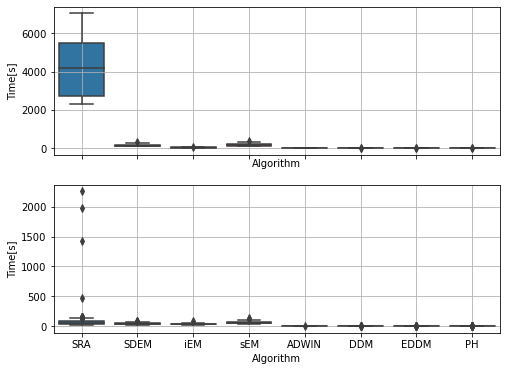

In [50]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

sns.boxplot(x='variable', y='value', data=time_by_trial_df_melted, ax=axes[0])
axes[0].set_xlabel('Algorithm')
axes[0].set_ylabel('Time[s]')
#ax.set_yscale('log')
axes[0].grid()

sns.boxplot(x='Algorithm', y='Time', data=time_by_each_df, ax=axes[1])
axes[1].set_ylabel('Time[s]')
#axes[1].set_yscale('log')
axes[1].grid()

plt.show()

## MSE

In [80]:
def experiment1_comparison_mse(
    # SDEM
    r_list_sdem=[0.0001, 0.001, 0.005, 0.01], 
    # SEM
    r_list_sem=[0.01, 0.05, 0.1],
    # SRA
    gamma_list_sra=[1, 3, 5, 10, 15], 
    u=10, 
    N=10000,
    alpha_ol=0.01, # ratio of outliers
    eval_start=500,
    eval_end=1000,
    burnin=1000,
    mu1=np.array([0.5]),
    mu2=np.array([1.0]),
    cps=np.array([9999]),
    start=0, 
    end=None,
    T=100,
    N_thr=1000,
    n_trial=10):

    mse_sdem_eval, mse_sdem_former, mse_sdem_latter, mse_sdem_total = [], [], [], []
    mse_iem_eval, mse_iem_former, mse_iem_latter, mse_iem_total = [], [], [], []
    mse_sem_eval, mse_sem_former, mse_sem_latter, mse_sem_total = [], [], [], []
    mse_sra_eval, mse_sra_former, mse_sra_latter, mse_sra_total = [], [], [], []
    
    for trial in tqdm(range(n_trial)):
        # generate data
        np.random.seed(trial)
        X = np.zeros((2*N, 1))
        Xj_former = generate_data(N, pi, mu1, sigma)
        X[:N, 0] = Xj_former.ravel()
        Xj_latter = generate_data(N, pi, mu2, sigma)
        X[N:, 0] = Xj_latter.ravel()

        idxes_ol = np.random.choice(np.arange(N), int(alpha_ol*N))
        X[idxes_ol, :] = np.random.uniform(-u, u, len(idxes_ol)).reshape(-1, 1)    
        
        print('# SDEM')
        for i, r in enumerate(r_list_sdem):
            rho_const = np.repeat([r], 2*N)
            sdem = SDEM(rho_const, 1.0, n_components=1)
            #seed = i*len(r_list_sdem) + trial
            sdem.fit(X[:10, :])
            for t in range(X.shape[0]):
                sdem.update(X[t, :])
            
            means_est_sdem = np.array(sdem.means_list).reshape(2*N, 1)
            ev, former, latter, total = calc_metrics(means_est_sdem, mu1, mu2, eval_start, eval_end, burnin)
            mse_sdem_eval.append([trial, r, ev])
            mse_sdem_former.append([trial, r, former])
            mse_sdem_latter.append([trial, r, latter])
            mse_sdem_total.append([trial, r, total])
            
        print('# IEM')
        iem = SDEM(1.0/np.arange(1, 2*N+1), 1.0, n_components=1)
        iem.fit(X[:10, :])
        for t in range(X.shape[0]):
            iem.update(X[t, :])

        means_est_iem = np.array(iem.means_list).reshape(2*N, 1)
        ev, former, latter, total = calc_metrics(means_est_iem, mu1, mu2, eval_start, eval_end, burnin)
        mse_iem_eval.append([trial, ev])
        mse_iem_former.append([trial, former])
        mse_iem_latter.append([trial, latter])
        mse_iem_total.append([trial, total])
        
        print('# SEM')
        for i, r in enumerate(r_list_sem):
            seed = i*len(r_list_sem) + trial
            #np.random.seed(seed)
            
            rho_const = np.repeat([r], 2*N)
            #theta_est_sem = sem(X, theta0, rho_const)
            _, mu_est_sem, _ = sem(X, theta0, rho_const, start, end, seed)
            
            print(mu_est_sem)
            
            #ev, former, latter, total = calc_metrics(theta_est_sem[:, 3:5], mu1, mu2, eval_start, eval_end, burnin)
            ev, former, latter, total = calc_metrics(mu_est_sem, mu1, mu2, eval_start, eval_end, burnin)
            mse_sem_eval.append([trial, r, ev])
            mse_sem_former.append([trial, r, former])
            mse_sem_latter.append([trial, r, latter])
            mse_sem_total.append([trial, total])

        print('# SRA')
        for j, gamma in enumerate(gamma_list_sra):
            ratio_list = [0.01*gamma, 0.03*gamma, 0.05*gamma, 0.1*gamma]
            M_list = [gamma, 2*gamma, 4*gamma]
            for l, ratio in enumerate(ratio_list):
                for m, M in enumerate(M_list):
                    seed = j*len(gamma_list_sra) + l*len(ratio_list) + m * len(M_list) + trial
                    
                    np.random.seed(seed)
                    #theta_est_sra = sra(X, theta0, rho_const, gamma)
                    _, mu_est_sra, _ = sra(X, theta0, rho_const, gamma)
        
                    #ev, former, latter, total = calc_metrics(theta_est_sra[:, 3:5], mu1, mu2, eval_start, eval_end, burnin)
                    ev, former, latter, total = calc_metrics(mu_est_sra, mu1, mu2, eval_start, eval_end, burnin)
                    mse_sra_eval.append([trial, gamma, ratio, M, ev])
                    mse_sra_former.append([trial, gamma, ratio, M, former])
                    mse_sra_latter.append([trial, gamma, ratio, M, latter])
                    mse_sra_total.append([trial, gamma, ratio, M, total])
                    #former = np.sum((theta_est_sra[burnin:N+1, 3:5] - mu1)**2, axis=1)
                    #mse_sra_former.append([trial, gamma, ratio, M, former])
        
                    #latter = np.sum((theta_est_sra[N+1:, 3:5] - mu2)**2, axis=1)
                    #mse_sra_latter.append([trial, gamma, ratio, M, latter])
        
                    #overall = np.hstack((former, latter))
                    #mse_sra_total.append([trial, gamma, ratio, M, overall])

    mse_sdem_eval_df = pd.DataFrame(mse_sdem_eval, columns=['trial', 'r', 'mse'])
    mse_sdem_former_df = pd.DataFrame(mse_sdem_former, columns=['trial', 'r', 'mse'])
    mse_sdem_latter_df = pd.DataFrame(mse_sdem_latter, columns=['trial', 'r', 'mse'])
    mse_sdem_total_df = pd.DataFrame(mse_sdem_total, columns=['trial', 'r', 'mse'])

    mse_iem_eval_df = pd.DataFrame(mse_iem_eval, columns=['trial', 'mse'])
    mse_iem_former_df = pd.DataFrame(mse_iem_former, columns=['trial', 'mse'])
    mse_iem_latter_df = pd.DataFrame(mse_iem_latter, columns=['trial', 'mse'])
    mse_iem_total_df = pd.DataFrame(mse_iem_total, columns=['trial', 'mse'])

    mse_sem_eval_df = pd.DataFrame(mse_sem_eval, columns=['trial', 'r', 'mse'])
    mse_sem_former_df = pd.DataFrame(mse_sem_former, columns=['trial', 'r', 'mse'])
    mse_sem_latter_df = pd.DataFrame(mse_sem_latter, columns=['trial', 'r', 'mse'])
    mse_sem_total_df = pd.DataFrame(mse_sem_total, columns=['trial', 'r', 'mse'])

    mse_sra_eval_df = pd.DataFrame(mse_sra_eval, columns=['trial', 'r', 'mse'])
    mse_sra_former_df = pd.DataFrame(mse_sra_former, columns=['trial', 'r', 'mse'])
    mse_sra_latter_df = pd.DataFrame(mse_sra_latter, columns=['trial', 'r', 'mse'])
    mse_sra_total_df = pd.DataFrame(mse_sra_total, columns=['trial', 'r', 'mse'])


    return mse_sdem_eval_df, mse_sdem_former_df, mse_sdem_latter_df, mse_sdem_total_df, \
           mse_iem_eval_df, mse_iem_former_df, mse_iem_latter_df, mse_iem_total_df, \
           mse_sem_eval_df, mse_sem_former_df, mse_sem_latter_df, mse_sem_total_df, \
           mse_sra_eval_df, mse_sra_former_df, mse_sra_latter_df, mse_sra_total_df

In [62]:
mse_sdem_eval_df, mse_sdem_former_df, mse_sdem_latter_df, mse_sdem_total_df, \
mse_iem_eval_df, mse_iem_former_df, mse_iem_latter_df, mse_iem_total_df, \
mse_sem_eval_df, mse_sem_former_df, mse_sem_latter_df, mse_sem_total_df, \
mse_sra_eval_df, mse_sra_former_df, mse_sra_latter_df, mse_sra_total_df = experiment1_comparison_mse()

  0%|          | 0/10 [00:00<?, ?it/s]

# SDEM
former
(9000,)
[0.00429843 0.00429874 0.00429733 ... 0.00060354 0.0006034  0.00060392]
latter
(10000,)
[0.22598582 0.22594855 0.22588688 ... 0.0303161  0.03031373 0.0303088 ]
former
(9000,)
[5.64024484e-04 5.67139833e-04 5.63998455e-04 ... 9.95395678e-05
 9.94062230e-05 9.66384459e-05]
latter
(10000,)
[2.59428119e-01 2.58994324e-01 2.58300349e-01 ... 4.84481686e-06
 4.38065004e-06 4.23641119e-06]
former
(9000,)
[0.00029867 0.00031123 0.00030076 ... 0.00014238 0.00014135 0.00012501]
latter
(10000,)
[2.58802070e-01 2.56642460e-01 2.53209354e-01 ... 1.63961159e-05
 1.22465008e-05 1.10140243e-05]
former
(9000,)
[0.00085603 0.0008915  0.00084897 ... 0.00021433 0.00021102 0.00017117]
latter
(10000,)
[2.58221071e-01 2.53921518e-01 2.47141813e-01 ... 5.23048397e-05
 3.72216537e-05 3.26431356e-05]
# IEM
former
(9000,)
[1.83730162e-04 1.80959346e-04 1.81732140e-04 ... 1.43980999e-05
 1.43977186e-05 1.42965056e-05]
latter
(10000,)
[0.25374665 0.25370431 0.25363613 ... 0.06318152 0.06317786

/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
  0%|          | 0/10 [00:30<?, ?it/s]

[[[1.90178147]]

 [[1.90108747]]

 [[1.90041694]]

 ...

 [[1.0072322 ]]

 [[1.00610095]]

 [[1.00571341]]]
former
(9000, 1)
[[0.00092592]
 [0.00096203]
 [0.00091717]
 ...
 [0.00021433]
 [0.00021102]
 [0.00017117]]
latter
(10000, 1)
[[2.58221076e-01]
 [2.53921523e-01]
 [2.47141818e-01]
 ...
 [5.23046940e-05]
 [3.72215310e-05]
 [3.26430207e-05]]
